In [1]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.5 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import joblib
import datetime
import numpy as np

import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

import category_encoders as ce

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

plt.rcParams["figure.figsize"] = (9,6)

pd.options.mode.chained_assignment = None

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataDir = 'drive/MyDrive/Colab Notebooks/Lenta/data/'

**Загрузка датасета с лагами, но без бинарного кодирования**

In [5]:
data_r = pd.read_csv(dataDir+'df_1.csv')

In [6]:
data_r.head()

,Unnamed: 0,st_id,pr_sku_id,date,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,rolling_mean,сluster
0,0,42a0e188f5033bc65bf8d78622277c4e,5781a2637b476d781eb3134581b32044,2022-08-01,6512bd43d9caa6e02c990b0a82652dca,e58cc5ca94270acaceed13bc82dfedf7,aa50d6506c1e1b3f030c0b19962eb625,1,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105
1,1,f7e6c85504ce6e82442c770f7c8606f0,58ebafabd92e2e3a80d86b7bb7e88eda,2022-08-01,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,7a8aebb07d6e8ba9da453ec0f3f359a4,1,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105
2,2,c81e728d9d4c2f636f067f89cc14862c,82704fa1c2dbdb928bf4eed0667260dd,2022-08-01,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105
3,3,c81e728d9d4c2f636f067f89cc14862c,0cc8850f66397af21700e3c060a5210c,2022-08-01,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,1e2248e0a1305fdf1dca5510e06a2b96,17,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
4,4,c81e728d9d4c2f636f067f89cc14862c,178946dc0cfb8cbcb7b4e672930affd5,2022-08-01,6512bd43d9caa6e02c990b0a82652dca,c9f95a0a5af052bffce5c89917335f67,126ad03316db7675164e3f0c8be270e9,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105


In [7]:
data_r = data_r.dropna().reset_index()

In [8]:
data_r['date'].nunique()

324

In [9]:
data_r = data_r.drop(['index', 'Unnamed: 0', 'date'], axis=1)

In [10]:
data_r.head()

,st_id,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,rolling_mean,сluster
0,16a5cdae362b8d27a1d8f8c7b78b4330,6629d8e0d18c0b83c15006570566598f,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,34d2777e78ccf007523e2dd1fcea6b2d,17,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,...,6.0,1.0,10.0,14.0,3.0,3.0,4.0,3.0,5.428571,105
1,f7e6c85504ce6e82442c770f7c8606f0,b7e2077a3d7fa0d30e0eb5ec7fa349e8,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,7a8aebb07d6e8ba9da453ec0f3f359a4,1,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,...,6.0,4.0,12.0,15.0,8.0,7.0,9.0,4.0,7.357143,105
2,c81e728d9d4c2f636f067f89cc14862c,fdb89dfd1a27256904eb5a5734252102,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,567115097ac405a46a84ef641c2d7069,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,...,7.0,10.0,3.0,3.0,8.0,5.0,6.0,2.0,6.714286,105
3,16a5cdae362b8d27a1d8f8c7b78b4330,65ebd984baa08be2dcd09ff15c254fdb,c20ad4d76fe97759aa27a0c99bff6710,fb2fcd534b0ff3bbed73cc51df620323,ee7d94b81244a5f3b392d4113bacf408,1,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,...,13.0,18.0,10.0,23.0,12.0,9.0,14.0,7.0,12.928571,105
4,c81e728d9d4c2f636f067f89cc14862c,79122a5063b8a1261b8b1f03509ef957,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,89b0107c6d0aca5f15fa7a715f9e06e5,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,...,3.0,6.0,3.0,4.0,4.0,4.0,3.0,7.0,4.357143,105


In [11]:
df_train, df_test = train_test_split(data_r, shuffle=False, test_size=0.25)

In [12]:
features_train = df_train.drop(['target'], axis=1)
target_train = df_train['target']
features_test = df_test.drop(['target'], axis=1)
target_test = df_test['target']

## Рассмотренные гипотезы
- Генерадия дополнительных признаков (агрегированный спрос по группам на 2 недели вперед) с помощью [SARIMA (SARIMAX)](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) с последующим использованием в линейной регрессии
- линейная регрессия

## Метрика качества WAPE
❗ Округление

In [13]:
def wape_metric(target: np.array, prediction: np.array) -> float:
    return np.sum(np.abs(target - np.around(prediction, 0)))/np.sum(np.abs(target))
wape = make_scorer(wape_metric, greater_is_better=False)

## Категориальные признаки (Target Encoder)

Не уверен, насколько это корректно конкретно для TS
Вроде бы да, и [против утечки есть smoothing](https://towardsdatascience.com/dealing-with-categorical-variables-by-using-target-encoder-a0f1733a4c69), но например раньше в sklearn можно было для эого энкодера [задать количество фолдов на cv](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html), а значит и применить Timeseries split, [а теперь - нет](https://contrib.scikit-learn.org/category_encoders/targetencoder.html).
В теории можно кросс-валидацию переписать вручную, и на каждом шаге делать кодирование

In [14]:
categ = ['st_id', 'pr_sku_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'st_city_id', 'st_division_code', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'sup']

In [15]:
regr_encoder = ce.TargetEncoder(return_df=True, cols=categ).fit(features_train[categ], target_train)

In [16]:
features_train[categ] = regr_encoder.transform(features_train[categ])

In [17]:
features_test[categ] = regr_encoder.transform(features_test[categ])

## Масштабирование

In [18]:
regr_scaler = StandardScaler().fit(features_train)

## Линейная регрессия.

In [19]:
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=8)
result = abs(cross_val_score(model, regr_scaler.transform(features_train), target_train, cv=tscv, scoring='neg_mean_squared_error', verbose=1)) ** .5
print('RMSE ---', result)

RMSE --- [ 6.27185276  7.03142006  7.72102913 17.80990359  7.05099575 11.95947931
 10.82286525 11.79591863]


In [20]:
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=8)
result = abs(cross_val_score(model, regr_scaler.transform(features_train), target_train, cv=tscv, scoring=wape, verbose=1))
print('WAPE ---', result)

WAPE --- [0.45318434 0.46563576 0.45344525 0.57900234 0.5221951  0.52851432
 0.50637637 0.52579677]


## Линейная регрессия с уменьшенным числом признаков

(только id магазина, id товара, скользящее среднее и лаги)

In [21]:
data_r.columns

Index(['st_id', 'pr_sku_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id',
       'pr_uom_id', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'holiday', 'target', 'day_of_week',
       'weekend', 'day', 'sup', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'lag_25', 'lag_26', 'lag_27', 'lag_28', 'rolling_mean', 'сluster'],
      dtype='object')

In [22]:
features_train_small = features_train.drop(['pr_group_id', 'pr_cat_id', 'pr_subcat_id',
       'pr_uom_id', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'holiday', 'day_of_week',
       'weekend', 'day', 'sup', 'сluster'], axis=1)
target_train_small = target_train
regr_scaler_small = StandardScaler().fit(features_train_small)

In [23]:
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=8)
result = abs(cross_val_score(model, regr_scaler_small.transform(features_train_small), target_train_small, cv=tscv, scoring=wape, verbose=1))
print('WAPE ---', result)

WAPE --- [0.45095946 0.46161162 0.45226988 0.60579194 0.56062753 0.51218123
 0.50585774 0.51168493]


**А что если...**

In [24]:
features_train_very_small = features_train.drop(['pr_group_id', 'pr_cat_id', 'pr_subcat_id',
       'pr_uom_id', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'holiday', 'day_of_week',
       'weekend', 'day', 'sup', 'сluster', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'lag_25', 'lag_26', 'lag_27', 'lag_28'], axis=1)
target_train_very_small = target_train
regr_scaler_very_small = StandardScaler().fit(features_train_very_small)
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=8)
result = abs(cross_val_score(model, regr_scaler_very_small.transform(features_train_very_small), target_train_very_small, cv=tscv, scoring=wape, verbose=1))
print('WAPE ---', result)

WAPE --- [0.46861219 0.48608136 0.47659396 0.59719281 0.55865397 0.52114828
 0.52030719 0.5361699 ]


**Видно, что достаточно скользящего среднего и лагов**

In [25]:
model.fit(regr_scaler_small.transform(features_train_small), target_train_small)

LinearRegression()

## Тестовая выборка

In [26]:
features_test_small = features_test.drop(['pr_group_id', 'pr_cat_id', 'pr_subcat_id',
       'pr_uom_id', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'holiday', 'day_of_week',
       'weekend', 'day', 'sup', 'сluster'], axis=1)

In [27]:
predictions = model.predict(regr_scaler_small.transform(features_test_small))

In [28]:
result = wape_metric(target_test, predictions)

In [29]:
result

0.4877875061326918

## Подготовка агрегированных данных для Sarima

In [30]:
data_s = pd.read_csv(dataDir+'df_1.csv')
data_s = data_s.dropna().reset_index()
data_s = data_s.drop(['index', 'Unnamed: 0'], axis=1)
data_s.head()

,st_id,pr_sku_id,date,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,rolling_mean,сluster
0,16a5cdae362b8d27a1d8f8c7b78b4330,6629d8e0d18c0b83c15006570566598f,2022-08-29,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,34d2777e78ccf007523e2dd1fcea6b2d,17,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,...,6.0,1.0,10.0,14.0,3.0,3.0,4.0,3.0,5.428571,105
1,f7e6c85504ce6e82442c770f7c8606f0,b7e2077a3d7fa0d30e0eb5ec7fa349e8,2022-08-29,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,7a8aebb07d6e8ba9da453ec0f3f359a4,1,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,...,6.0,4.0,12.0,15.0,8.0,7.0,9.0,4.0,7.357143,105
2,c81e728d9d4c2f636f067f89cc14862c,fdb89dfd1a27256904eb5a5734252102,2022-08-29,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,567115097ac405a46a84ef641c2d7069,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,...,7.0,10.0,3.0,3.0,8.0,5.0,6.0,2.0,6.714286,105
3,16a5cdae362b8d27a1d8f8c7b78b4330,65ebd984baa08be2dcd09ff15c254fdb,2022-08-29,c20ad4d76fe97759aa27a0c99bff6710,fb2fcd534b0ff3bbed73cc51df620323,ee7d94b81244a5f3b392d4113bacf408,1,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,...,13.0,18.0,10.0,23.0,12.0,9.0,14.0,7.0,12.928571,105
4,c81e728d9d4c2f636f067f89cc14862c,79122a5063b8a1261b8b1f03509ef957,2022-08-29,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,89b0107c6d0aca5f15fa7a715f9e06e5,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,...,3.0,6.0,3.0,4.0,4.0,4.0,3.0,7.0,4.357143,105


In [31]:
data_s = data_s.drop(['pr_cat_id', 'st_id', 'pr_sku_id', 'pr_subcat_id',
       'pr_uom_id', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'holiday', 'day_of_week',
       'weekend', 'day', 'sup', 'сluster'], axis=1)

In [32]:
data_s.head()

,date,pr_group_id,target,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,rolling_mean
0,2022-08-29,c74d97b01eae257e44aa9d5bade97baf,3.0,6.0,9.0,5.0,5.0,5.0,4.0,4.0,6.0,1.0,10.0,14.0,3.0,3.0,4.0,3.0,5.428571
1,2022-08-29,aab3238922bcc25a6f606eb525ffdc56,5.0,8.0,6.0,6.0,15.0,4.0,3.0,4.0,6.0,4.0,12.0,15.0,8.0,7.0,9.0,4.0,7.357143
2,2022-08-29,aab3238922bcc25a6f606eb525ffdc56,9.0,4.0,8.0,3.0,15.0,14.0,3.0,7.0,7.0,10.0,3.0,3.0,8.0,5.0,6.0,2.0,6.714286
3,2022-08-29,c20ad4d76fe97759aa27a0c99bff6710,6.0,12.0,16.0,17.0,12.0,11.0,13.0,6.0,13.0,18.0,10.0,23.0,12.0,9.0,14.0,7.0,12.928571
4,2022-08-29,c74d97b01eae257e44aa9d5bade97baf,4.0,3.0,6.0,6.0,4.0,3.0,6.0,2.0,3.0,6.0,3.0,4.0,4.0,4.0,3.0,7.0,4.357143


In [33]:
df_s_train, df_s_test = train_test_split(data_s, shuffle=False, test_size=0.25)

**Сформируем временные ряды продаж, агрегированные по группам товаров (Среднее значение)**

In [34]:
data_s['pr_group_id'].nunique()

8

In [35]:
series_list = []
for gr in df_s_train['pr_group_id'].unique():
  data = df_s_train.loc[df_s_train['pr_group_id']==gr].groupby('date').agg({'target': 'mean'}).fillna(0)
  data.columns = data.columns.map(''.join)
  series_list.append(data)

In [36]:
series_list[0].shape

(252, 1)

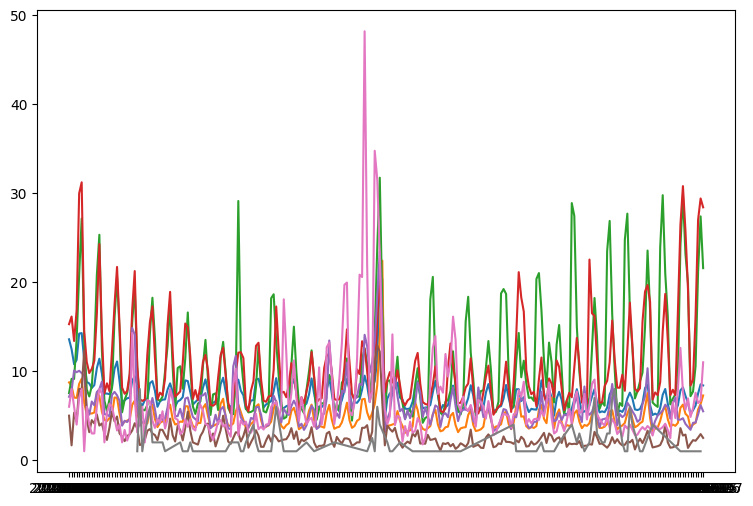

In [37]:
for s in series_list:
  plt.plot(s['target'])
plt.show()

Интересно что это за пик такой...

Коэффициенты модели (p, d, q) = (1,0,0), [взято значение](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)  s = 12 (месячный период) Блоки для кросс-валидации формируются в цикле из конца выборки, поскольку по умолчанию SARIMAX с TimeSeriesSplit не работает

In [38]:
len(series_list)

8

In [39]:
s = 12
it = 0
for s in series_list:
  features_train = s.drop(['target'], axis=1)
  target_train = s['target']
  rmse = []
  valid_percent = .25
  valid_size = int(valid_percent * features_train.shape[0])
  for cv in range(int(1 / valid_percent - 1)):
    train_end = features_train.shape[0] - (cv + 1) * valid_size
    valid_end = train_end + valid_size
    features_train_cv = features_train[:train_end]
    target_train_cv = target_train[:train_end]
    features_valid_cv = features_train[train_end:valid_end]
    target_valid_cv = target_train[train_end:valid_end]
    sarima = SARIMAX(target_train_cv, order = (1, 0, 0), seasonal_order = (1, 1, 1, 12))
    result = sarima.fit()
    predictions = result.predict(1, target_valid_cv.shape[0])
    rmse.append(mean_squared_error(predictions, target_valid_cv) ** .5)
  it += 1
  print(f'GROUP {it} --- RMSE MEAN ---{sum(rmse) / len(rmse)}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

GROUP 1 --- RMSE MEAN ---3.6492103332065358


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

GROUP 2 --- RMSE MEAN ---2.612363225401601


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

GROUP 3 --- RMSE MEAN ---7.847660973495356


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

GROUP 4 --- RMSE MEAN ---6.787674370292343


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

GROUP 5 --- RMSE MEAN ---3.569494500240836


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

GROUP 6 --- RMSE MEAN ---2.535028215514673


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


GROUP 7 --- RMSE MEAN ---6.011591059328978


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


GROUP 8 --- RMSE MEAN ---2.7900059294243316


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


**Предсказания на 14 дней вперед**

In [40]:
predictions = []
it = 0
for s in series_list:
  features_train = s.drop(['target'], axis=1)
  target_train = s['target']
  pred = result.predict(features_train.shape[0], features_train.shape[0] + 14).map(int)
  print('GROUP---', it)
  print(pred)
  it += 1
  predictions.append(pred)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/u

GROUP--- 0
252    1
253    1
254    1
255    1
256    1
257    1
258    1
259    1
260    1
261    1
262    0
263    0
264    1
265    1
266    1
Name: predicted_mean, dtype: int64
GROUP--- 1
252    1
253    1
254    1
255    1
256    1
257    1
258    1
259    1
260    1
261    1
262    0
263    0
264    1
265    1
266    1
Name: predicted_mean, dtype: int64
GROUP--- 2
252    1
253    1
254    1
255    1
256    1
257    1
258    1
259    1
260    1
261    1
262    0
263    0
264    1
265    1
266    1
Name: predicted_mean, dtype: int64
GROUP--- 3
252    1
253    1
254    1
255    1
256    1
257    1
258    1
259    1
260    1
261    1
262    0
263    0
264    1
265    1
266    1
Name: predicted_mean, dtype: int64
GROUP--- 4
252    1
253    1
254    1
255    1
256    1
257    1
258    1
259    1
260    1
261    1
262    0
263    0
264    1
265    1
266    1
Name: predicted_mean, dtype: int64
GROUP--- 5
252    1
253    1
254    1
255    1
256    1
257    1
258    1
259    1
260    1
261

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/u

Не взлетело. Предсказания продаж по группам какие-то абсурдные

## VARMAX
- [VARMAX](https://www.statsmodels.org/stable/vector_ar.html#var) модель для прогнозирования многомерных временных рядов

In [41]:
sales = pd.DataFrame()
for s in series_list:
  s = s['target']
  sales = pd.concat([sales, s], axis=1)

In [42]:
sales

,target,target,target,target,target,target,target,target
2022-08-29,13.579235,8.743590,7.538462,15.280000,7.125000,5.000000,6.000000,NaN
2022-08-30,12.472803,8.324176,9.136364,16.136364,7.800000,1.666667,8.000000,NaN
2022-08-31,10.773649,7.030043,9.125000,13.388889,10.071429,5.333333,NaN,NaN
2022-09-01,11.263636,7.000000,13.600000,16.850000,9.882353,4.333333,4.000000,NaN
2022-09-02,14.220708,8.577465,20.840909,29.972603,10.047619,8.000000,7.000000,NaN
...,...,...,...,...,...,...,...,...
2023-05-03,5.615702,4.014311,7.716049,9.030303,4.197531,2.250000,5.842105,NaN
2023-05-04,6.145861,4.188679,10.563218,16.144068,4.231481,2.181818,7.578947,1.0
2023-05-05,7.484812,5.696343,21.224490,27.012295,5.121429,2.533333,6.421053,1.0
2023-05-06,8.523985,6.314662,27.390000,29.405983,6.175182,2.928571,6.692308,1.0


In [43]:
sales = sales.fillna(0)

In [44]:
sales.tail()

,target,target,target,target,target,target,target,target
2023-05-03,5.615702,4.014311,7.716049,9.030303,4.197531,2.250000,5.842105,0.0
2023-05-04,6.145861,4.188679,10.563218,16.144068,4.231481,2.181818,7.578947,1.0
2023-05-05,7.484812,5.696343,21.224490,27.012295,5.121429,2.533333,6.421053,1.0
2023-05-06,8.523985,6.314662,27.390000,29.405983,6.175182,2.928571,6.692308,1.0
2023-05-07,8.398281,7.272340,21.571429,28.405941,5.489362,2.500000,11.000000,0.0


In [45]:
varmax = VARMAX(sales, freq = 'D', order = (1, 0, 0), seasonal_order = (1, 1, 1, 12))
fitted = varmax.fit(disp=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
predict = fitted.get_prediction(start=len(sales) + 1, end=len(sales) + 14)
forecast = predict.predicted_mean.astype('int')
forecast.columns = data_s['pr_group_id'].unique()
forecast_train = forecast
forecast_train

,c74d97b01eae257e44aa9d5bade97baf,aab3238922bcc25a6f606eb525ffdc56,c20ad4d76fe97759aa27a0c99bff6710,6512bd43d9caa6e02c990b0a82652dca,c51ce410c124a10e0db5e4b97fc2af39,1ff1de774005f8da13f42943881c655f,32bb90e8976aab5298d5da10fe66f21d,98f13708210194c475687be6106a3b84
2023-05-09,8,5,19,21,6,3,8,1
2023-05-10,8,5,18,19,6,3,7,1
2023-05-11,8,5,16,17,6,3,6,0
2023-05-12,8,5,14,15,6,3,6,0
2023-05-13,8,5,13,14,6,3,6,0
2023-05-14,7,5,12,13,6,3,6,0
2023-05-15,7,5,12,12,6,3,6,0
2023-05-16,7,5,11,12,6,2,6,0
2023-05-17,7,5,11,11,6,2,6,0
2023-05-18,7,5,11,11,6,2,6,0


**И для тестовой выборки**

In [47]:
series_list_test = []
for gr in df_s_test['pr_group_id'].unique():
  data = df_s_test.loc[df_s_test['pr_group_id']==gr].groupby('date').agg({'target': 'mean'}).fillna(0)
  data.columns = data.columns.map(''.join)
  series_list_test.append(data)

In [48]:
sales_test = pd.DataFrame()
for s in series_list_test:
  sales_test = pd.concat([sales_test, s], axis=1)

In [49]:
sales_test = sales_test.fillna(0)

In [50]:
predict = fitted.get_prediction(start=len(sales) + len(sales_test) - 1, end=len(sales) + len(sales_test) + 12)
forecast = predict.predicted_mean.astype('int')
forecast.columns = data_s['pr_group_id'].unique()
forecast_test = forecast
forecast_test

,c74d97b01eae257e44aa9d5bade97baf,aab3238922bcc25a6f606eb525ffdc56,c20ad4d76fe97759aa27a0c99bff6710,6512bd43d9caa6e02c990b0a82652dca,c51ce410c124a10e0db5e4b97fc2af39,1ff1de774005f8da13f42943881c655f,32bb90e8976aab5298d5da10fe66f21d,98f13708210194c475687be6106a3b84
2023-07-19,7,4,11,11,6,2,6,0
2023-07-20,7,4,11,11,6,2,6,0
2023-07-21,7,4,11,11,6,2,6,0
2023-07-22,7,4,11,11,6,2,6,0
2023-07-23,7,4,11,11,6,2,6,0
2023-07-24,7,4,11,11,6,2,6,0
2023-07-25,7,4,11,11,6,2,6,0
2023-07-26,7,4,11,11,6,2,6,0
2023-07-27,7,4,11,11,6,2,6,0
2023-07-28,7,4,11,11,6,2,6,0


очень странно.....
почему-то нам обещают пугающую стабильность

**Теперь вернемся к датасету для линейной регрессии и добавим туда еще 14 признаков по группам**

In [51]:
forecast_train = forecast_train.reset_index().drop(['index'], axis=1)
forecast_test = forecast_test.reset_index().drop(['index'], axis=1)

In [52]:
forecast_train

,c74d97b01eae257e44aa9d5bade97baf,aab3238922bcc25a6f606eb525ffdc56,c20ad4d76fe97759aa27a0c99bff6710,6512bd43d9caa6e02c990b0a82652dca,c51ce410c124a10e0db5e4b97fc2af39,1ff1de774005f8da13f42943881c655f,32bb90e8976aab5298d5da10fe66f21d,98f13708210194c475687be6106a3b84
0,8,5,19,21,6,3,8,1
1,8,5,18,19,6,3,7,1
2,8,5,16,17,6,3,6,0
3,8,5,14,15,6,3,6,0
4,8,5,13,14,6,3,6,0
5,7,5,12,13,6,3,6,0
6,7,5,12,12,6,3,6,0
7,7,5,11,12,6,2,6,0
8,7,5,11,11,6,2,6,0
9,7,5,11,11,6,2,6,0


In [53]:
def add_data(dataset, forecast):
  features_add = pd.DataFrame()
  for c in forecast.columns:
    data = dataset.loc[dataset['pr_group_id']==c]
    for j in range(forecast.shape[0]):
      new_name = 'future_'+str(j)
      data[new_name] = forecast.loc[j, c]
    features_add = pd.concat((features_add, data), axis=0)
  return features_add

In [54]:
df_train = add_data(df_train, forecast_train)
df_test = add_data(df_test, forecast_test)

In [55]:
features_train = df_train.drop(['target'], axis=1)
target_train = df_train['target']
features_test = df_test.drop(['target'], axis=1)
target_test = df_test['target']

In [56]:
features_train[categ] = regr_encoder.transform(features_train[categ])
features_test[categ] = regr_encoder.transform(features_test[categ])

In [57]:
features_train

,st_id,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,...,future_4,future_5,future_6,future_7,future_8,future_9,future_10,future_11,future_12,future_13
0,7.965274,3.352317,7.240857,10.401891,8.094337,8.019482,7.965274,7.422741,7.201046,7.965274,...,8,7,7,7,7,7,7,7,7,7
4,8.312876,2.236295,7.240857,10.401891,6.684600,6.376806,7.299425,7.299425,7.201046,6.804148,...,8,7,7,7,7,7,7,7,7,7
5,8.312876,4.519425,7.240857,10.401891,13.056459,8.019482,7.299425,7.299425,7.201046,6.804148,...,8,7,7,7,7,7,7,7,7,7
7,8.312876,11.064157,7.240857,10.401891,6.684600,8.019482,7.299425,7.299425,7.201046,6.804148,...,8,7,7,7,7,7,7,7,7,7
8,8.312876,8.803030,7.240857,10.401891,8.094337,8.019482,7.299425,7.299425,7.201046,6.804148,...,8,7,7,7,7,7,7,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383668,6.218108,2.038677,2.166629,2.166629,2.166629,6.376806,6.218108,6.218108,7.201046,6.804148,...,0,0,0,0,0,0,0,0,0,0
388792,6.218108,2.038677,2.166629,2.166629,2.166629,6.376806,6.218108,6.218108,7.201046,6.804148,...,0,0,0,0,0,0,0,0,0,0
393577,6.218108,2.038677,2.166629,2.166629,2.166629,6.376806,6.218108,6.218108,7.201046,6.804148,...,0,0,0,0,0,0,0,0,0,0
395149,6.218108,2.038677,2.166629,2.166629,2.166629,6.376806,6.218108,6.218108,7.201046,6.804148,...,0,0,0,0,0,0,0,0,0,0


In [58]:
features_train = features_train.drop(['pr_group_id', 'pr_cat_id', 'pr_subcat_id',
       'pr_uom_id', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'holiday', 'day_of_week',
       'weekend', 'day', 'sup', 'сluster'], axis=1)
features_test = features_test.drop(['pr_group_id', 'pr_cat_id', 'pr_subcat_id',
       'pr_uom_id', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'holiday', 'day_of_week',
       'weekend', 'day', 'sup', 'сluster'], axis=1)

In [59]:
add_scaler = StandardScaler()
add_scaler.fit(features_train)

StandardScaler()

In [60]:
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
result = abs(cross_val_score(model, add_scaler.transform(features_train), target_train, cv=tscv, scoring='neg_mean_squared_error', verbose=1))
print('RMSE ---', result)

RMSE --- [1.91128710e+02 8.94042645e+11 3.72826411e+01 6.34369897e+08
 6.99555033e+09]


In [61]:
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
result = abs(cross_val_score(model, add_scaler.transform(features_train), target_train, cv=tscv, scoring=wape, verbose=1))
print('WAPE ---', result)

WAPE --- [4.48441609e-01 1.03363948e+05 4.47467556e-01 2.11645717e+03
 3.63061483e+03]


**Тестовая выборка**

In [62]:
model.fit(add_scaler.transform(features_train), target_train)
predictions = model.predict(add_scaler.transform(features_test))

In [63]:
result = wape_metric(target_test, predictions)
result

0.48740669997209435

## Вывод

Можно сказать следующее:

- для линейной регрессии главные признаки это лаговые значенияи скользящее среднее
добавление дополнительных признаков, таких как прогнозы средних групповых продаж по VARMAX прироста метрики не дали, однако разброс значений метрики на кросс-валидации стал гораздо больше